[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-5/memoryschema_profile.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/59970910-lesson-3-memory-schema-profile)

# 프로필 스키마를 사용하는 챗봇

## 복습

우리는 장기 기억을 저장하고 검색하는 방법으로 [LangGraph 메모리 스토어](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore)를 소개했습니다.

또한 `단기 (스레드 내)` 메모리와 `장기 (스레드 간)` 메모리를 모두 사용하는 간단한 챗봇을 만들었습니다.

이 챗봇은 사용자와 대화하는 중에 실시간으로["in the hot path"](https://langchain-ai.github.io/langgraph/concepts/memory/#writing-memories) 장기 [의미 기억(semantic memory)](https://langchain-ai.github.io/langgraph/concepts/memory/#semantic-memory)(사용자에 대한 사실)을 저장했습니다.

## 목표

이전 챗봇은 메모리를 문자열로 저장했습니다. 하지만 실제로는 메모리에 구조를 부여하는 것이 더 유용할 때가 많습니다.

예를 들어, 메모리는 [지속적으로 업데이트되는 단일 스키마](https://langchain-ai.github.io/langgraph/concepts/memory/#profile)가 될 수 있습니다.

이번 예제에서는 이것을 단일 사용자 프로필로 만들어 보겠습니다.

챗봇을 확장하여 의미 기억을 단일 [사용자 프로필](https://langchain-ai.github.io/langgraph/concepts/memory/#profile)에 저장하도록 만들 것입니다.

또한, 새로운 정보로 이 스키마를 업데이트하기 위해 [Trustcall](https://github.com/hinthornw/trustcall) 라이브러리를 소개할 것입니다.

In [1]:
%%capture --no-stderr

%pip install -U langchain_openai langgraph trustcall langchain_core

In [2]:
from dotenv import load_dotenv

load_dotenv("../.env", override=True)

True

In [ ]:
import os
import getpass


def _set_env(var: str):
    env_value = os.environ.get(var)
    if not env_value:
        env_value = getpass.getpass(f"{var}: ")

    os.environ[var] = env_value

In [4]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## 사용자 프로필 스키마 정의

파이썬에는 TypedDict, 딕셔너리, JSON, [Pydantic](https://docs.pydantic.dev/latest/)과 같이 [구조화된 데이터](https://python.langchain.com/docs/concepts/structured_outputs/#schema-definition)를 위한 다양한 타입이 있습니다.

먼저 TypedDict를 사용하여 사용자 프로필 스키마를 정의해 보겠습니다.

In [5]:
from typing import TypedDict, List


class UserProfile(TypedDict):
    """타입이 지정된 필드를 가진 사용자 프로필 스키마"""

    user_name: str  # 사용자가 선호하는 이름
    interests: List[str]  # 사용자의 관심사 목록

## 스키마를 저장소에 저장하기

[LangGraph 저장소](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore)는 모든 파이썬 딕셔너리를 `value`로 받습니다.

In [9]:
# TypedDict 인스턴스
user_profile: UserProfile = {
    "user_name": "랜스",
    "interests": ["자전거 타기", "기술", "커피"],
}
user_profile

{'user_name': '랜스', 'interests': ['자전거 타기', '기술', '커피']}

[put](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.put) 메서드를 사용하여 TypedDict를 스토어에 저장합니다.

In [10]:
import uuid
from langgraph.store.memory import InMemoryStore

# 인메모리 저장소 초기화
in_memory_store = InMemoryStore()

# 저장할 메모리의 네임스페이스
user_id = "1"
namespace_for_memory = (user_id, "memory")

# 네임스페이스에 메모리를 키와 값으로 저장
key = "user_profile"
value = user_profile
in_memory_store.put(namespace_for_memory, key, value)

[search](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.search)를 사용하여 네임스페이스로 저장소에서 객체를 검색합니다.

In [11]:
# 검색
for m in in_memory_store.search(namespace_for_memory):
    print(m.dict())

{'namespace': ['1', 'memory'], 'key': 'user_profile', 'value': {'user_name': '랜스', 'interests': ['자전거 타기', '기술', '커피']}, 'created_at': '2025-10-02T08:02:49.497091+00:00', 'updated_at': '2025-10-02T08:02:49.497094+00:00', 'score': None}


또한 [get](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.get)을 사용하여 네임스페이스와 키로 특정 객체를 검색할 수도 있습니다.

In [12]:
# 네임스페이스와 키로 메모리 가져오기
profile = in_memory_store.get(namespace_for_memory, "user_profile")
profile.value

{'user_name': '랜스', 'interests': ['자전거 타기', '기술', '커피']}

## 프로필 스키마를 사용하는 챗봇

이제 메모리에 대한 스키마를 지정하고 스토어에 저장하는 방법을 알게 되었습니다.

그렇다면, 이 특정 스키마에 맞춰 어떻게 메모리를 *생성*할 수 있을까요?

우리가 만드는 챗봇에서는 [사용자와의 채팅으로부터 메모리를 생성](https://langchain-ai.github.io/langgraph/concepts/memory/#profile)하고자 합니다.

바로 이럴 때 [구조화된 출력(structured outputs)](https://python.langchain.com/docs/concepts/structured_outputs/#recommended-usage)이라는 개념이 유용합니다.

LangChain의 [채팅 모델](https://python.langchain.com/docs/concepts/chat_models/) 인터페이스에는 구조화된 출력을 강제하는 [`with_structured_output`](https://www.google.com/search?q=%5Bhttps://python.langchain.com/docs/concepts/structured_outputs/%23recommended-usage%5D\(https://python.langchain.com/docs/concepts/structured_outputs/%23recommended-usage\)) 메서드가 있습니다.

이 기능은 출력이 특정 스키마를 따르도록 강제하고, 그 결과를 자동으로 파싱해주기 때문에 유용합니다.

In [13]:
_set_env("OPENAI_API_KEY")

생성한 `UserProfile` 스키마를 `with_structured_output` 메서드에 전달해 보겠습니다.

그런 다음 [메시지](https://python.langchain.com/docs/concepts/messages/) 목록으로 채팅 모델을 호출하여 스키마를 따르는 구조화된 출력을 얻을 수 있습니다.

In [15]:
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI

# 모델 초기화
model = ChatOpenAI(model="gpt-4o", temperature=0)

# 스키마를 모델에 바인딩
model_with_structure = model.with_structured_output(UserProfile)

# 스키마와 일치하는 구조화된 출력을 생성하기 위해 모델 호출
structured_output = model_with_structure.invoke(
    [HumanMessage("제 이름은 랜스입니다. 자전거 타는 걸 좋아합니다.")]
)
structured_output

{'user_name': '랜스', 'interests': ['자전거 타기']}

이제 이것을 우리 챗봇과 함께 사용해 봅시다.

이는 `write_memory` 함수에 약간의 변경만 필요합니다.

위에서 정의한 `model_with_structure`를 사용하여 스키마와 일치하는 프로필을 생성합니다.

In [16]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_core.runnables.config import RunnableConfig

# 챗봇 지침
MODEL_SYSTEM_MESSAGE = """당신은 사용자에 대한 정보를 제공하는 기억력을 가진 유용한 어시스턴트입니다.
이 사용자에 대한 기억이 있다면, 그것을 사용하여 응답을 개인화하세요.
여기 기억이 있습니다 (비어 있을 수 있습니다): {memory}"""

# 채팅 기록과 기존 메모리에서 새 메모리 생성
CREATE_MEMORY_INSTRUCTION = """사용자의 채팅 기록을 기반으로 사용자 프로필 메모리를 생성하거나 업데이트하세요.
이것은 장기 기억을 위해 저장될 것입니다. 기존 메모리가 있다면 간단히 업데이트하세요.
여기 기존 메모리가 있습니다 (비어 있을 수 있습니다): {memory}"""


def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """저장소에서 메모리를 로드하고 이를 사용하여 챗봇의 응답을 개인화합니다."""
    # 설정에서 사용자 ID 가져오기
    user_id = config["configurable"]["user_id"]

    # 저장소에서 메모리 검색
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # 시스템 프롬프트를 위한 메모리 형식 지정
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"이름: {memory_dict.get('user_name', '알 수 없음')}\n"
            f"관심사: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None

    # 시스템 프롬프트에서 메모리 형식 지정
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)

    # 메모리와 채팅 기록을 사용하여 응답
    response = model.invoke([SystemMessage(content=system_msg)] + state["messages"])

    return {"messages": response}


def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """채팅 기록을 검토하고 저장소에 메모리를 저장합니다."""

    # 설정에서 사용자 ID 가져오기
    user_id = config["configurable"]["user_id"]

    # 저장소에서 기존 메모리 검색
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # 시스템 프롬프트를 위한 메모리 형식 지정
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"이름: {memory_dict.get('user_name', '알 수 없음')}\n"
            f"관심사: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None

    # 지침에서 기존 메모리 형식 지정
    system_msg = CREATE_MEMORY_INSTRUCTION.format(memory=formatted_memory)

    # 스키마와 일치하는 구조화된 출력을 생성하기 위해 모델 호출
    new_memory = model_with_structure.invoke(
        [SystemMessage(content=system_msg)] + state["messages"]
    )

    # 기존 사용자 프로필 메모리를 덮어씁니다.
    key = "user_memory"
    store.put(namespace, key, new_memory)

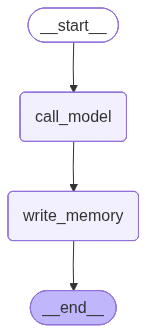

In [17]:
# 그래프 정의
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)

builder.set_entry_point("call_model")
builder.add_edge("call_model", "write_memory")
builder.set_finish_point("write_memory")

# 장기(스레드 간) 메모리를 위한 저장소
across_thread_memory = InMemoryStore()

# 단기(스레드 내) 메모리를 위한 체크포인터
within_thread_memory = MemorySaver()

# 체크포인터와 저장소를 사용하여 그래프 컴파일
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# 보기
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [18]:
# 단기(스레드 내) 메모리를 위해 스레드 ID를 제공합니다.
# 장기(스레드 간) 메모리를 위해 사용자 ID를 제공합니다.
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# 사용자 입력
input_messages = [
    HumanMessage(
        content="안녕하세요, 제 이름은 Lance이고 샌프란시스코 주변에서 자전거 타는 것과 빵집에서 먹는 것을 좋아합니다."
    )
]

# 그래프 실행
for chunk in graph.stream(
    {"messages": input_messages},
    config,
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

안녕하세요, 제 이름은 Lance이고 샌프란시스코 주변에서 자전거 타는 것과 빵집에서 먹는 것을 좋아합니다.
================================== Ai Message ==================================

안녕하세요, Lance! 샌프란시스코는 자전거 타기에 정말 멋진 장소죠. 특히 경치가 아름다운 곳이 많아서 더욱 즐거울 것 같아요. 그리고 빵집에서 맛있는 빵을 먹는 것도 큰 즐거움이죠. 혹시 샌프란시스코에서 추천할 만한 자전거 경로나 빵집이 있나요?


저장소의 메모리를 확인해 봅시다.

메모리가 우리 스키마와 일치하는 딕셔너리임을 알 수 있습니다.

In [19]:
# 저장할 메모리의 네임스페이스
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.value

{'user_name': 'Lance',
 'interests': ['cycling around San Francisco', 'eating at bakeries']}

## 어떤 경우에 실패할 수 있을까요?

[`with_structured_output`](https://www.google.com/search?q=%5Bhttps://python.langchain.com/docs/concepts/structured_outputs/%23recommended-usage)은 매우 유용하지만, 더 복잡한 스키마로 작업하는 경우에는 어떻게 될까요?

더 복잡한 스키마의 예시가 [여기](https://github.com/hinthornw/trustcall?tab=readme-ov-file#complex-schema)에 있으며, 아래에서 테스트해 보겠습니다.

이것은 사용자의 커뮤니케이션 및 트러스트 폴(trust fall)에 대한 선호도를 설명하는 [Pydantic](https://docs.pydantic.dev/latest/) 모델입니다.

In [20]:
from typing import List, Optional


class OutputFormat(BaseModel):
    preference: str
    sentence_preference_revealed: str


class TelegramPreferences(BaseModel):
    preferred_encoding: Optional[List[OutputFormat]] = None
    favorite_telegram_operators: Optional[List[OutputFormat]] = None
    preferred_telegram_paper: Optional[List[OutputFormat]] = None


class MorseCode(BaseModel):
    preferred_key_type: Optional[List[OutputFormat]] = None
    favorite_morse_abbreviations: Optional[List[OutputFormat]] = None


class Semaphore(BaseModel):
    preferred_flag_color: Optional[List[OutputFormat]] = None
    semaphore_skill_level: Optional[List[OutputFormat]] = None


class TrustFallPreferences(BaseModel):
    preferred_fall_height: Optional[List[OutputFormat]] = None
    trust_level: Optional[List[OutputFormat]] = None
    preferred_catching_technique: Optional[List[OutputFormat]] = None


class CommunicationPreferences(BaseModel):
    telegram: TelegramPreferences
    morse_code: MorseCode
    semaphore: Semaphore


class UserPreferences(BaseModel):
    communication_preferences: CommunicationPreferences
    trust_fall_preferences: TrustFallPreferences


class TelegramAndTrustFallPreferences(BaseModel):
    pertinent_user_preferences: UserPreferences

이제 `with_structured_output` 메서드를 사용하여 이 스키마의 추출을 시도해 보겠습니다.

In [22]:
from pydantic import ValidationError

# 스키마를 모델에 바인딩
model_with_structure = model.with_structured_output(TelegramAndTrustFallPreferences)

# 대화
conversation = """교환원: 전보를 어떻게 도와드릴까요, 손님?
고객: 신뢰 낙하 운동에 대한 메시지를 보내야 합니다.
교환원: 알겠습니다. 모스 부호인가요, 아니면 표준 인코딩인가요?
고객: 모스 부호로 부탁합니다. 스트레이트 키를 사용하는 것을 좋아하거든요.
교환원: 훌륭합니다. 메시지가 무엇인가요?
고객: 더 높은 낙하에 준비되었고, 잡는 데는 다이아몬드 포메이션을 선호한다고 전해주세요.
교환원: 완료되었습니다. 이 대담한 메시지에 저희 \"데어데블\" 용지를 사용할까요?
고객: 완벽해요! 가장 빠른 비둘기 전송으로 보내주세요.
교환원: 한 시간 안에 도착할 겁니다, 손님."""

# 모델 호출
try:
    model_with_structure.invoke(f"""다음 대화에서 선호도를 추출하세요:
    <convo>
    {conversation}
    </convo>""")
except ValidationError as e:
    print(e)

`gpt-4o`와 같은 고성능 모델을 사용하더라도, 더 복잡한 스키마를 단순하게 추출하려고 하면 실패하기 쉽습니다.

## 프로필 스키마 생성 및 업데이트를 위한 Trustcall

보시다시피, 스키마 작업은 까다로울 수 있습니다.

복잡한 스키마는 추출하기 어려울 수 있습니다.

또한, 간단한 스키마를 업데이트하는 것조차 어려울 수 있습니다.

위에서 만든 챗봇을 생각해 봅시다.

새로운 메모리를 저장하기로 할 때마다 프로필 스키마를 *처음부터* 다시 생성했습니다.

이는 스키마에 매번 다시 생성해야 할 정보가 많이 포함되어 있는 경우 모델 토큰을 낭비할 수 있으므로 비효율적입니다.

더 나쁜 것은, 프로필을 처음부터 다시 생성할 때 정보가 손실될 수 있다는 점입니다.

이러한 문제를 해결하는 것이 바로 [TrustCall](https://github.com/hinthornw/trustcall)의 동기입니다!

이것은 LangChain 팀의 [Will Fu-Hinthorn](https://github.com/hinthornw)이 개발한 JSON 스키마 업데이트를 위한 오픈 소스 라이브러리입니다.

이 라이브러리는 바로 메모리 작업 중에 겪는 이러한 어려움에서 영감을 얻었습니다.

먼저, 이 [메시지](https://python.langchain.com/docs/concepts/messages/) 목록에서 TrustCall을 사용하여 간단하게 추출하는 방법을 보여드리겠습니다.

In [23]:
# 대화
conversation = [
    HumanMessage(content="안녕하세요, 저는 Lance입니다."),
    AIMessage(content="만나서 반가워요, Lance."),
    HumanMessage(content="저는 샌프란시스코 주변에서 자전거 타는 것을 정말 좋아해요."),
]

`create_extractor`를 사용할 때, 모델과 함께 우리의 스키마를 [tool(도구)](https://python.langchain.com/docs/concepts/tools/)로 전달합니다.

TrustCall에서는 다양한 방법으로 스키마를 제공할 수 있습니다.

예를 들어, JSON 객체/파이썬 딕셔너리 또는 Pydantic 모델을 전달할 수 있습니다.

내부적으로, TrustCall은 입력된 [메시지](https://python.langchain.com/docs/concepts/messages/) 목록으로부터 [구조화된 출력](https://python.langchain.com/docs/concepts/structured_outputs/)을 생성하기 위해 [tool calling(도구 호출)](https://python.langchain.com/docs/concepts/tool_calling/)을 사용합니다.

Trustcall이 [구조화된 출력](https://python.langchain.com/docs/concepts/structured_outputs/)을 생성하도록 강제하려면, `tool_choice` 인자에 스키마 이름을 포함시키면 됩니다.

위 대화를 사용하여 추출기를 호출할 수 있습니다.

In [ ]:
from trustcall import create_extractor


# 스키마
class UserProfile(BaseModel):
    """타입이 지정된 필드를 가진 사용자 프로필 스키마"""

    user_name: str = Field(description="사용자가 선호하는 이름")
    interests: List[str] = Field(description="사용자의 관심사 목록")


# 모델 초기화
model = ChatOpenAI(model="gpt-4o", temperature=0)

# 추출기 생성
trustcall_extractor = create_extractor(
    model,
    tools=[UserProfile],
    tool_choice="UserProfile",  # UserProfile 도구 사용을 강제합니다.
)

# 지침
system_msg = "다음 대화에서 사용자 프로필을 추출하세요."

# 추출기 호출
result = trustcall_extractor.invoke(
    {"messages": [SystemMessage(content=system_msg)] + conversation}
)

추출기를 호출하면 몇 가지를 얻게 됩니다:

* `messages`: 도구 호출을 포함하는 `AIMessages` 목록.

* `responses`: 스키마와 일치하는 결과로 파싱된 도구 호출.

* `response_metadata`: 기존 도구 호출을 업데이트할 때 적용됩니다. 어떤 응답이 어떤 기존 객체에 해당하는지를 나타냅니다.

In [26]:
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  UserProfile (call_mYEyeID6cZ5P6gG7hblGtKap)
 Call ID: call_mYEyeID6cZ5P6gG7hblGtKap
  Args:
    user_name: Lance
    interests: ['자전거 타기', '샌프란시스코']


In [35]:
schema = result["responses"]
schema

[UserProfile(user_name='Lance', interests=['자전거 타기', '샌프란시스코'])]

In [36]:
schema[0].model_dump()

{'user_name': 'Lance', 'interests': ['자전거 타기', '샌프란시스코']}

In [37]:
result["response_metadata"]

[{'id': 'call_uAEgIKFoah7yFoMC6LUVv4cs'}]

이제 이것을 사용하여 프로필을 _수정(update)_ 하는 방법을 살펴보겠습니다.

수정 작업을 위해, TrustCall은 메시지 집합과 기존 스키마를 함께 입력으로 받습니다.

핵심 아이디어는 모델이 스키마의 관련 부분만 업데이트하도록 [JSON Patch](https://jsonpatch.com/)를 생성하게 하는 것입니다.

이 방법은 전체 스키마를 단순히 덮어쓰는 것보다 오류가 발생할 가능성이 적습니다.

또한 모델이 변경된 부분의 스키마만 생성하면 되므로 더 효율적입니다.

기존 스키마를 딕셔너리(dict)로 저장할 수 있습니다.

Pydantic 모델 인스턴스는 `model_dump()`를 사용하여 딕셔너리로 직렬화할 수 있습니다.

이것을 스키마 이름인 `UserProfile`과 함께 `"existing"` 인자에 전달합니다.

In [38]:
# 대화 업데이트
updated_conversation = [
    HumanMessage(content="안녕하세요, 저는 Lance입니다."),
    AIMessage(content="만나서 반가워요, Lance."),
    HumanMessage(content="저는 샌프란시스코 주변에서 자전거 타는 것을 정말 좋아해요."),
    AIMessage(content="샌프란시스코는 멋진 도시죠! 자전거 탄 후에는 어디로 가시나요?"),
    HumanMessage(content="자전거 탄 후에 빵집에 가는 것을 정말 좋아해요."),
]

# 지침 업데이트
system_msg = "다음 대화에서 새로운 정보를 통합하도록 메모리(JSON 문서)를 업데이트하세요"

# 업데이트된 지침과 해당 도구 이름(UserProfile)이 있는 기존 프로필로 추출기 호출
result = trustcall_extractor.invoke(
    {"messages": [SystemMessage(content=system_msg)] + updated_conversation},
    {"existing": {"UserProfile": schema[0].model_dump()}},
)

In [39]:
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  UserProfile (call_RpJ3qNa8xD2Vvu7dkcJcw9r7)
 Call ID: call_RpJ3qNa8xD2Vvu7dkcJcw9r7
  Args:
    user_name: Lance
    interests: ['cycling around San Francisco', 'visiting bakeries']


In [40]:
result["response_metadata"]

[{'id': 'call_RpJ3qNa8xD2Vvu7dkcJcw9r7'}]

In [41]:
updated_schema = result["responses"][0]
updated_schema.model_dump()

{'user_name': 'Lance',
 'interests': ['cycling around San Francisco', 'visiting bakeries']}

LangSmith 트레이스:

https://smith.langchain.com/public/229eae22-1edb-44c6-93e6-489124a43968/r

이제, 이전에 보았던 [까다로운 스키마](https://github.com/hinthornw/trustcall?tab=readme-ov-file#complex-schema)에 대해서도 Trustcall을 테스트해 봅시다.

In [42]:
bound = create_extractor(
    model,
    tools=[TelegramAndTrustFallPreferences],
    tool_choice="TelegramAndTrustFallPreferences",
)

In [43]:
# 대화
conversation = """교환원: 전보를 어떻게 도와드릴까요, 손님?
고객: 신뢰 낙하 운동에 대한 메시지를 보내야 합니다.
교환원: 알겠습니다. 모스 부호인가요, 아니면 표준 인코딩인가요?
고객: 모스 부호로 부탁합니다. 스트레이트 키를 사용하는 것을 좋아하거든요.
교환원: 훌륭합니다. 메시지가 무엇인가요?
고객: 더 높은 낙하에 준비되었고, 잡는 데는 다이아몬드 포메이션을 선호한다고 전해주세요.
교환원: 완료되었습니다. 이 대담한 메시지에 저희 \"데어데블\" 용지를 사용할까요?
고객: 완벽해요! 가장 빠른 비둘기 전송으로 보내주세요.
교환원: 한 시간 안에 도착할 겁니다, 손님."""

result = bound.invoke(
    f"""다음 대화에서 선호도를 추출하세요:
    <convo>
    {conversation}
    </convo>"""
)

# 선호도 추출
result["responses"][0]

TelegramAndTrustFallPreferences(pertinent_user_preferences=UserPreferences(communication_preferences=CommunicationPreferences(telegram=TelegramPreferences(preferred_encoding=[OutputFormat(preference='standard encoding', sentence_preference_revealed='표준 인코딩')], favorite_telegram_operators=None, preferred_telegram_paper=[OutputFormat(preference='데어데블 용지', sentence_preference_revealed='데어데블 용지 사용')]), morse_code=MorseCode(preferred_key_type=[OutputFormat(preference='straight key', sentence_preference_revealed='스트레이트 키 사용')], favorite_morse_abbreviations=None), semaphore=Semaphore(preferred_flag_color=None, semaphore_skill_level=None)), trust_fall_preferences=TrustFallPreferences(preferred_fall_height=[OutputFormat(preference='higher', sentence_preference_revealed='더 높은 낙하')], trust_level=None, preferred_catching_technique=[OutputFormat(preference='diamond formation', sentence_preference_revealed='다이아몬드 포메이션')])))

트레이스:

https://smith.langchain.com/public/5cd23009-3e05-4b00-99f0-c66ee3edd06e/r

더 많은 예제는 [여기](https://www.youtube.com/watch?v=-H4s0jQi-QY)에서 개요 비디오를 볼 수 있습니다.

## 프로필 스키마 업데이트 기능이 있는 챗봇

이제 Trustcall을 챗봇에 도입하여 메모리 프로필을 *생성하고 업데이트*해 봅시다.

In [ ]:
from IPython.display import Image, display
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.runnables.config import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore

# 모델 초기화
model = ChatOpenAI(model="gpt-4o", temperature=0)


# 스키마
class UserProfile(BaseModel):
    """사용자 프로필"""

    user_name: str = Field(description="사용자가 선호하는 이름")
    user_location: str = Field(description="사용자의 위치")
    interests: list = Field(description="사용자의 관심사 목록")


# 추출기 생성
trustcall_extractor = create_extractor(
    model,
    tools=[UserProfile],
    tool_choice="UserProfile",  # UserProfile 도구 사용을 강제합니다.
)

# 챗봇 지침
MODEL_SYSTEM_MESSAGE = """당신은 사용자에 대한 정보를 제공하는 기억력을 가진 유용한 어시스턴트입니다.
이 사용자에 대한 기억이 있다면, 그것을 사용하여 응답을 개인화하세요.
여기 기억이 있습니다 (비어 있을 수 있습니다): {memory}"""

# 추출 지침
TRUSTCALL_INSTRUCTION = (
    """다음 대화의 정보를 통합하여 메모리(JSON 문서)를 생성하거나 업데이트하세요:"""
)


def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """저장소에서 메모리를 로드하고 이를 사용하여 챗봇의 응답을 개인화합니다."""

    # 설정에서 사용자 ID 가져오기
    user_id = config["configurable"]["user_id"]

    # 저장소에서 메모리 검색
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # 시스템 프롬프트를 위한 메모리 형식 지정
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"이름: {memory_dict.get('user_name', '알 수 없음')}\n"
            f"위치: {memory_dict.get('user_location', '알 수 없음')}\n"
            f"관심사: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None

    # 시스템 프롬프트에서 메모리 형식 지정
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)

    # 메모리와 채팅 기록을 사용하여 응답
    response = model.invoke([SystemMessage(content=system_msg)] + state["messages"])
    return {"messages": response}


def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """채팅 기록을 검토하고 저장소에 메모리를 저장합니다."""

    # 설정에서 사용자 ID 가져오기
    user_id = config["configurable"]["user_id"]

    # 저장소에서 기존 메모리 검색
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # 목록에서 값을 프로필로 가져와 JSON 문서로 변환
    existing_profile = (
        {"UserProfile": existing_memory.value} if existing_memory else None
    )

    # 추출기 호출
    result = trustcall_extractor.invoke(
        {
            "messages": [SystemMessage(content=TRUSTCALL_INSTRUCTION)]
            + state["messages"],
            "existing": existing_profile,
        }
    )
    # 업데이트된 프로필을 JSON 객체로 가져오기
    updated_profile = result["responses"][0].model_dump()

    # 업데이트된 프로필 저장
    key = "user_memory"
    store.put(namespace, key, updated_profile)

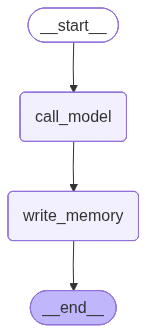

In [ ]:
# 그래프 정의
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)

builder.set_entry_point("call_model")
builder.add_edge("call_model", "write_memory")
builder.set_finish_point("write_memory")

# 장기(스레드 간) 메모리를 위한 저장소
across_thread_memory = InMemoryStore()

# 단기(스레드 내) 메모리를 위한 체크포인터
within_thread_memory = MemorySaver()

# 체크포인터와 저장소를 사용하여 그래프 컴파일
graph = builder.compile(
    checkpointer=within_thread_memory,
    store=across_thread_memory,
)

# 보기
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
# 단기(스레드 내) 메모리를 위해 스레드 ID를 제공합니다.
# 장기(스레드 간) 메모리를 위해 사용자 ID를 제공합니다.
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# 사용자 입력
input_messages = [HumanMessage(content="안녕하세요, 제 이름은 Lance입니다")]

# 그래프 실행
for chunk in graph.stream(
    {"messages": input_messages},
    config,
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

안녕하세요, 제 이름은 Lance입니다
================================== Ai Message ==================================

안녕하세요, Lance님! 만나서 반갑습니다. 오늘 어떻게 도와드릴까요?


In [ ]:
# 사용자 입력
input_messages = [
    HumanMessage(content="저는 샌프란시스코 주변에서 자전거 타는 것을 좋아해요")
]

# 그래프 실행
for chunk in (
    graph.stream({"messages": input_messages}, config, stream_mode="values"),
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

저는 샌프란시스코 주변에서 자전거 타는 것을 좋아해요
================================== Ai Message ==================================

샌프란시스코는 자전거 타기에 정말 멋진 장소죠! 금문교를 건너거나 골든 게이트 파크를 탐험하는 것도 좋을 것 같아요. Lance님이 가장 좋아하는 자전거 경로가 있나요?


In [48]:
# 저장할 메모리의 네임스페이스
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.dict()

{'namespace': ['memory', '1'],
 'key': 'user_memory',
 'value': {'user_name': 'Lance',
  'user_location': 'San Francisco',
  'interests': ['cycling']},
 'created_at': '2025-10-02T08:12:48.675908+00:00',
 'updated_at': '2025-10-02T08:12:48.675909+00:00'}

In [49]:
# JSON 객체로 저장된 사용자 프로필
existing_memory.value

{'user_name': 'Lance',
 'user_location': 'San Francisco',
 'interests': ['cycling']}

In [ ]:
# 사용자 입력
input_messages = [HumanMessage(content="빵집에 가는 것도 즐겨요")]

# 그래프 실행
for chunk in graph.stream(
    {"messages": input_messages},
    config,
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

빵집에 가는 것도 즐겨요
================================== Ai Message ==================================

자전거를 타고 샌프란시스코의 멋진 빵집을 탐험하는 것은 정말 좋은 아이디어네요! Tartine Bakery나 Boudin Bakery 같은 곳은 어떠세요? Lance님이 추천하는 빵집이 있나요?


새 스레드에서 대화를 계속합니다.

In [ ]:
# 단기(스레드 내) 메모리를 위해 스레드 ID를 제공합니다.
# 장기(스레드 간) 메모리를 위해 사용자 ID를 제공합니다.
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# 사용자 입력
input_messages = [HumanMessage(content="저에게 추천할 만한 빵집이 있나요?")]

# 그래프 실행
for chunk in graph.stream(
    {"messages": input_messages},
    config,
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

저에게 추천할 만한 빵집이 있나요?
================================== Ai Message ==================================

샌프란시스코에는 훌륭한 빵집들이 많이 있습니다. 사이클링을 좋아하신다고 하셨으니, 자전거로 방문하기 좋은 몇 곳을 추천드릴게요.

1. **Tartine Bakery**: 미션 지구에 위치한 이 빵집은 신선한 빵과 페이스트리로 유명합니다. 자전거를 타고 가기에 좋은 위치에 있으며, 항상 많은 사람들이 찾는 곳입니다.

2. **B. Patisserie**: 퍼시픽 하이츠에 있는 이곳은 프랑스 스타일의 페이스트리와 크루아상으로 유명합니다. 자전거를 타고 가면 주변 경치도 즐길 수 있습니다.

3. **Arizmendi Bakery**: 이곳은 협동조합으로 운영되며, 다양한 빵과 피자, 페이스트리를 제공합니다. 자전거로 방문하기에 좋은 위치에 있습니다.

이 빵집들은 모두 독특한 매력을 가지고 있으니, 방문해 보시면 좋을 것 같습니다!


## LangSmith

트레이스:

https://smith.langchain.com/public/f45bdaf0-6963-4c19-8ec9-f4b7fe0f68ad/r

## 스튜디오

![Screenshot 2024-10-30 at 11.26.31 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/6732d0437060f1754ea79908_Screenshot%202024-11-11%20at%207.48.53%E2%80%AFPM.png)